<center>
    <h1>Room Occupancy Estimation - DM, TM and BDA</h1>
    <h2>Support Vector Machine</h2>
    <h3>Riccardo Spolaor</h3>
    <h4>riccardo.spolaor@studio.unibo.it</h4>
</center>

---
In this notebook the prediction task on the ***Room Occupancy Estimation*** dataset is carried out by means of a Support Vector Machine.

## Settings

In [1]:
import sys

IS_COLAB = 'google.colab' in sys.modules

In [2]:
SEED=42

In [3]:
# Settings for autoreloading

%load_ext autoreload
%autoreload 2

In [4]:
# Matplotlib settings

%matplotlib inline

In [5]:
NUM_FOLDS = 10
APPLY_THRESHOLD_SELECTION = False

## Libraries

In [6]:
if IS_COLAB:
    !pip install pyspark
    !pip install findspark

In [7]:
import findspark

findspark.init()

In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
import pyspark.sql.functions as F

## Setting Spark Session

In [10]:
from pyspark.sql import SparkSession


# Create a spark session
spark = SparkSession.builder.master('local[*]').appName('OccupancyEstimation').getOrCreate()

In [11]:
if not IS_COLAB:
    # Put the local file in the nodes.
    !/usr/local/hadoop-3.3.4/bin/hadoop fs -mkdir /input
    !/usr/local/hadoop-3.3.4/bin/hadoop fs -mkdir /input/processed
    !/usr/local/hadoop-3.3.4/bin/hadoop fs -put input/processed/train.csv /input/processed/train.csv
    !/usr/local/hadoop-3.3.4/bin/hadoop fs -put input/processed/test.csv /input/processed/test.csv

## Get the train and test data

In [12]:
import os


if IS_COLAB:
    train_path = os.path.join('.', 'input', 'processed', 'train.csv')
    test_path = os.path.join('.', 'input', 'processed', 'test.csv')
else:
    train_path = os.path.join('/', 'input', 'processed', 'train.csv')
    test_path = os.path.join('/', 'input', 'processed', 'test.csv')

In [13]:
train = spark.read.csv(
    train_path,
    header=True,
    inferSchema=True)

test = spark.read.csv(
    test_path,
    header=True,
    inferSchema=True)

In [14]:
train.printSchema()
test.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- S1_Temp: double (nullable = true)
 |-- S2_Temp: double (nullable = true)
 |-- S3_Temp: double (nullable = true)
 |-- S4_Temp: double (nullable = true)
 |-- S1_Light: integer (nullable = true)
 |-- S2_Light: integer (nullable = true)
 |-- S3_Light: integer (nullable = true)
 |-- S4_Light: integer (nullable = true)
 |-- S1_Sound: double (nullable = true)
 |-- S2_Sound: double (nullable = true)
 |-- S3_Sound: double (nullable = true)
 |-- S4_Sound: double (nullable = true)
 |-- S5_CO2: integer (nullable = true)
 |-- S5_CO2_Slope: double (nullable = true)
 |-- S6_PIR: integer (nullable = true)
 |-- S7_PIR: integer (nullable = true)
 |-- Room_Occupancy_Count: integer (nullable = true)

root
 |-- Date: date (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- S1_Temp: double (nullable = true)
 |-- S2_Temp: double (nullable = true)
 |-- S3_Temp: double (nullable = true)
 |-- S4_Temp: double (nullable =

In [15]:
print('Number of train instances:', train.count())
print('Number of test instances:', test.count())

Number of train instances: 8036
Number of test instances: 2093


## Dataset Processing
In this section the dataset is processed, by adding a weight column to each instance inversely proportional to the frequency of their label, in order to address the issue of class imbalance.

The applied weight $w$, to an instance $x$ of the train dataset $\mathcal{D}$ with label $c$, is assigned by this formula:
$$w(x) = \frac{\text{lenght}(\mathcal{D})}{\text{lenght}(\mathcal{C}) \cdot \text{lenght}(\mathcal{D}_{c})}$$
where $\mathcal{D}_{c}$ is the fraction of the train dataset containing label $c$ and $\mathcal{C}$ is the set of possible labels.

Furthermore a fold column is added, to identify for each instance in which fold of the *K-fold Cross Validation* it is part of.
The folds are computed by dividing each day in $10$ different parts while guaranteeing that each fold contains a number of instances of each label that represents the distribution of the training set. Subsequent instances for each label are assigned to the same fold.

In [16]:
from pyspark.ml.feature import StandardScaler, RFormula


rf = RFormula(formula='Room_Occupancy_Count ~ . - Date - Time')
rf_fit = rf.fit(train)
train = rf_fit.transform(train).select('features', 'label', 'Date', 'Time')
test = rf_fit.transform(test).select('features', 'label', 'Date', 'Time')

In [17]:
train.show(n=5)
test.show(n=5)

+--------------------+-----+----------+-------------------+
|            features|label|      Date|               Time|
+--------------------+-----+----------+-------------------+
|[24.94,24.75,24.5...|  1.0|2017-12-22|2023-11-22 10:49:41|
|[24.94,24.75,24.5...|  1.0|2017-12-22|2023-11-22 10:50:12|
|[25.0,24.75,24.5,...|  1.0|2017-12-22|2023-11-22 10:50:42|
|[25.0,24.75,24.56...|  1.0|2017-12-22|2023-11-22 10:51:13|
|[25.0,24.75,24.56...|  1.0|2017-12-22|2023-11-22 10:51:44|
+--------------------+-----+----------+-------------------+
only showing top 5 rows

+--------------------+-----+----------+-------------------+
|            features|label|      Date|               Time|
+--------------------+-----+----------+-------------------+
|[25.94,26.0,25.75...|  0.0|2017-12-22|2023-11-22 15:00:23|
|[25.94,26.0,25.75...|  0.0|2017-12-22|2023-11-22 15:00:53|
|[25.94,26.0,25.75...|  0.0|2017-12-22|2023-11-22 15:01:24|
|[25.88,26.0,25.75...|  0.0|2017-12-22|2023-11-22 15:01:55|
|[25.88,26.0,25

In [18]:
from utils import get_df_with_weight_column


# Add weight column inversely proportional to train frequency of the label.
train = get_df_with_weight_column(train)

In [19]:
train.select('label', 'weightCol').distinct().orderBy('label').show()

+-----+-------------------+
|label|          weightCol|
+-----+-------------------+
|  0.0|0.30374962201390987|
|  1.0|  6.069486404833837|
|  2.0|   3.20414673046252|
|  3.0|  4.329741379310345|
+-----+-------------------+



In [20]:
from utils import get_df_with_fold_column


# Add the column for stratified k-fold.
train = get_df_with_fold_column(train, NUM_FOLDS)

In [21]:
# Drop the Date and Time features.
train = train.drop('Date', 'Time')
test = test.drop('Date', 'Time')

In [22]:
train.groupBy('foldCol', 'label').count().orderBy('foldCol', 'label').show()

+-------+-----+-----+
|foldCol|label|count|
+-------+-----+-----+
|      0|  0.0|  664|
|      0|  1.0|   34|
|      0|  2.0|   64|
|      0|  3.0|   48|
|      1|  0.0|  662|
|      1|  1.0|   33|
|      1|  2.0|   63|
|      1|  3.0|   46|
|      2|  0.0|  661|
|      2|  1.0|   34|
|      2|  2.0|   62|
|      2|  3.0|   46|
|      3|  0.0|  662|
|      3|  1.0|   32|
|      3|  2.0|   64|
|      3|  3.0|   47|
|      4|  0.0|  660|
|      4|  1.0|   33|
|      4|  2.0|   61|
|      4|  3.0|   46|
+-------+-----+-----+
only showing top 20 rows



In [23]:
train.show(n=5)

+-----+--------------------+-----------------+-------+
|label|            features|        weightCol|foldCol|
+-----+--------------------+-----------------+-------+
|  1.0|[24.94,24.75,24.5...|6.069486404833837|      0|
|  1.0|[24.94,24.75,24.5...|6.069486404833837|      0|
|  1.0|[25.0,24.75,24.5,...|6.069486404833837|      0|
|  1.0|[25.0,24.75,24.56...|6.069486404833837|      0|
|  1.0|[25.0,24.75,24.56...|6.069486404833837|      0|
+-----+--------------------+-----------------+-------+
only showing top 5 rows



## K-Fold Cross Validation Training
In this section a pipeline is built for the Support Vector Machine model. Since multiclassification is not natively supported for the given model, a *One Vs Rest* strategy is used to classify each instance. The feature are normalized throgh *Standard Scaling* because the model is expected to perform better that way.

*10-Fold Cross Validation* is then applied for different parameters, namely:
* `regParam`
* `fitIntercept`
* `tol`

In [26]:
from pyspark.ml.classification import LinearSVC, OneVsRest
from pyspark.ml import Pipeline, PipelineModel

def get_pipeline() -> PipelineModel:
    # Create SVM Classifier.
    svm = OneVsRest(
        classifier=LinearSVC(
            standardization=True,
            weightCol='weightCol'),
        weightCol='weightCol',
        parallelism=4)

    return Pipeline(stages=[svm])

In [27]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


# Cache the df.
cached = train.cache()

pipeline = get_pipeline()
svm = pipeline.getStages()[-1].getClassifier()

# Build the Parameter Grid.
svm_param_grid = ParamGridBuilder()\
    .addGrid(svm.regParam, [0.0001, .01, 1., 10.])\
    .addGrid(svm.fitIntercept, [True, False])\
    .addGrid(svm.tol, [1e-1, 1e-3])\
    .build()

# Set the Cross Validator.
svm_cross_val = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=svm_param_grid,
    evaluator=MulticlassClassificationEvaluator(
        metricName='f1', weightCol='weightCol'),
    numFolds=NUM_FOLDS,
    parallelism=NUM_FOLDS,
    collectSubModels=True,
    seed=SEED,
    foldCol='foldCol')

In [28]:
fit = svm_cross_val.fit(cached)

In [29]:
print('Best parameters:')
for k, v in fit.getEstimatorParamMaps()[np.argmax(fit.avgMetrics)].items():
    print(f'- {k.name}: {v}')

Best parameters:
- regParam: 0.0001
- fitIntercept: False
- tol: 0.001


## Average Results on the Validation Folds
In this section, the average results of *Cross Validation* of the model with the best found hyperparameters are computed and shown.

Threshold selection is not applied, as probabilities are not outputed for *OneVsRest* models.

In [30]:
from utils import get_average_validation_results


avg_validation_results = get_average_validation_results(
    fit,
    train,
    apply_threshold_selection=APPLY_THRESHOLD_SELECTION)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Average Cross Validation Metrics:
Accuracy: 0.970
F1 Macro: 0.892
F1 scores:
	Label 0: 0.996
	Label 1: 0.948
	Label 3: 0.810
	Label 2: 0.813


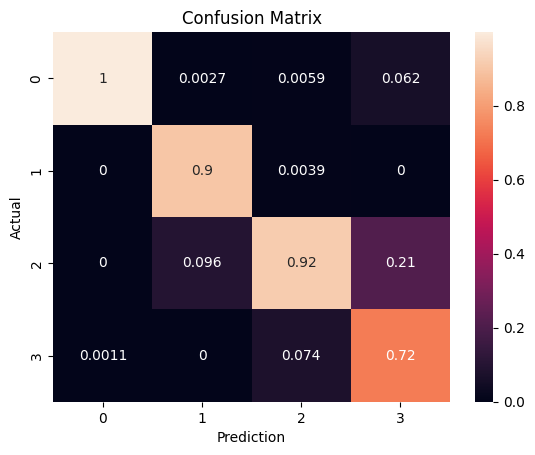

In [31]:
from utils import print_results


print('Average Cross Validation Metrics:')
print_results(
    avg_validation_results['average accuracy'],
    avg_validation_results['average F1 macro'],
    avg_validation_results['average F1 scores'],
    avg_validation_results['average confusion matrix'])

The model seems to predict good to average results for each class in the k-folded validation set. Label $2$ and $3$ seems to be the hardest to predict.

## Test Results
In this section the results are plotted for the test set, with the model containing the best found hyperparameters.

In [32]:
fit_final = fit.bestModel

In [33]:
preds = fit_final.transform(test)

In [34]:
from utils import get_metrics


fit_final_metrics = get_metrics(
    preds,
    normalize_confusion_matrix=True)

Test results:
Accuracy: 0.950
F1 Macro: 0.854
F1 scores:
	Label 0: 0.999
	Label 1: 0.996
	Label 2: 0.700
	Label 3: 0.719


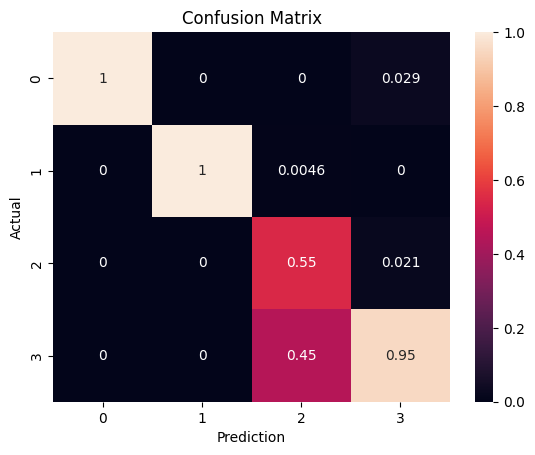

In [35]:
from utils import print_results


print('Test results:')
print_results(
    fit_final_metrics['accuracy'],
    fit_final_metrics['F1 macro'],
    fit_final_metrics['F1 scores'],
    fit_final_metrics['confusion matrix'])

The test results are slightly, but they respect the ones found in the validation as labels $0$ and $1$ still obtain good results, while labels $2$ and $3$ are average.

## Save the results

In [36]:
import os

models_directory = os.path.join('.', 'model', 'svm')
os.makedirs(models_directory, exist_ok=True)

results_directory = os.path.join('.', 'results', 'svm')
os.makedirs(results_directory, exist_ok=True)

In [37]:
import os
import pickle

# Save model and threshold model.
fit_final.save(os.path.join(models_directory, 'fit.model'))

with open(os.path.join(results_directory, 'val.pickle'), 'wb') as f:
    pickle.dump(avg_validation_results, f)

with open(os.path.join(results_directory, 'test.pickle'), 'wb') as f:
    pickle.dump(fit_final_metrics, f)